In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from DecisionTree import DecisionTree
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from BaggingClassifier import BaggingClassifier
%run DecisionTree.py


In [116]:
# Load dataset
data = pd.read_csv('heart.csv')
# Binary encoding for 'Sex' and 'ExerciseAngina'
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['ExerciseAngina'] = data['ExerciseAngina'].map({'Y': 1, 'N': 0})
# Extract features and labels
X = data.drop(columns=['HeartDisease'])
y = data['HeartDisease']

In [117]:
# One-Hot Encoding for non-binary categorical features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
encoder = OneHotEncoder(sparse=False)

if categorical_cols:  # Only encode if there are categorical features
    encoded_array = encoder.fit_transform(X[categorical_cols])
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))
    X = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)

X = X.to_numpy()
y = y.to_numpy()

In [118]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#X_val (10%) → Used for hyperparameter tuning.
# X_test (20%) → Used for final evaluation.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp
)


In [154]:
# tune the hyperparameters of the DecisionTree model
max_depths = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
min_samples_splits = [2, 4, 6, 8, 10, 20, 40, 60, 80, 100]

# Initialize best hyperparameters
best_max_depth = None
best_min_samples_split = None
best_accuracy = 0

# Tune hyperparameters
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        model = DecisionTree(max_depth=max_depth, min_sample_split=min_samples_split)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        if accuracy > best_accuracy:
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            best_accuracy = accuracy
            

In [156]:
# Train the DecisionTree model with the best hyperparameters
model = DecisionTree(max_depth=best_max_depth, min_sample_split=best_min_samples_split)
model.fit(X_train, y_train)

# get predictions and accuracy of the DecisionTree model on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of DecisionTree: {accuracy}")

Accuracy of DecisionTree: 0.8152173913043478


F1 Score of DecisionTree: 0.8247422680412372


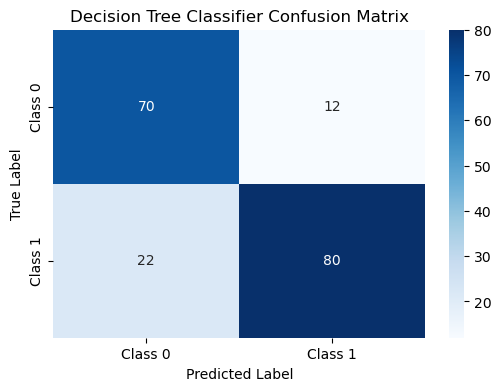

In [ ]:
# calculate the F1 score of the DecisionTree model
f1 = f1_score(y_test, y_pred)
print(f"F1 Score of DecisionTree: {f1}")
# Plot Confusion Matrix for DecisionTree
conf_matrix = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(conf_matrix, "Decision Tree Classifier Confusion Matrix")

In [158]:
# train sklearn's DecisionTreeClassifier
sklearn_model = DecisionTreeClassifier(random_state=42)
sklearn_model.fit(X_train, y_train)

# predict on validation set
val_set = sklearn_model.predict(X_val)
# compute accuracy
accuracy = accuracy_score(y_val, val_set)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8587


In [122]:
# Train the Bagging Classifier
bagging_model = BaggingClassifier(base_learner=DecisionTree, n_estimators=20)
bagging_model.fit(X_train, y_train)


use X_val to tune the model during training, and use X_test to evaluate the model after training.

In [123]:
# Predict using Bagging Classifier
val_set = bagging_model.predict(X_val)
# Compute accuracy
accuracy = accuracy_score(y_val, val_set)
print(f"Bagging Classifier Validation Accuracy: {accuracy:.4f}")


Bagging Classifier Validation Accuracy: 0.8696


Bagging Classifier evaluation

In [124]:
# Predict using Bagging Classifier
y_pred = bagging_model.predict(X_test)

# Compute Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


In [125]:
# Print accuracy and F1-score
print(f"Bagging Classifier Test Accuracy: {accuracy:.4f}")
print(f"Bagging Classifier F1-Score: {f1:.4f}")

Bagging Classifier Test Accuracy: 0.8533
Bagging Classifier F1-Score: 0.8670


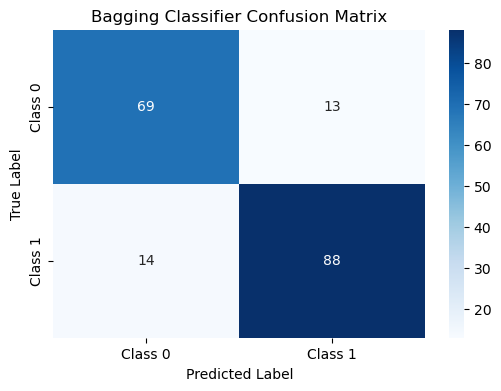

In [126]:
# Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(conf_matrix, "Bagging Classifier Confusion Matrix")

In [127]:
# Training KNN model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ---------------------------
#  Hyperparameter Tuning
# --------------------------

k_values = [3, 5, 11]
distance_metrics = ['euclidean', 'manhattan']

best_val_accuracy = 0
best_k = None
best_metric = None
best_model = None

for k in k_values:
    for metric in distance_metrics:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train_scaled, y_train)
        
        # Predict on the validation set
        y_val_pred = knn.predict(X_val_scaled)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        print(f"k: {k}, metric: {metric}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Update best model if current model is better
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_k = k
            best_metric = metric
            best_model = knn

print("\nBest Hyperparameters:")
print(f"Best k: {best_k}")
print(f"Best distance metric: {best_metric}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# ---------------------------
# Evaluation on Test Set
# ---------------------------
y_test_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

k: 3, metric: euclidean, Validation Accuracy: 0.8696
k: 3, metric: manhattan, Validation Accuracy: 0.9239
k: 5, metric: euclidean, Validation Accuracy: 0.8913
k: 5, metric: manhattan, Validation Accuracy: 0.9022
k: 11, metric: euclidean, Validation Accuracy: 0.8913
k: 11, metric: manhattan, Validation Accuracy: 0.8913

Best Hyperparameters:
Best k: 3
Best distance metric: manhattan
Best Validation Accuracy: 0.9239
Test Accuracy: 0.8533


c:\Users\bo2dy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\bo2dy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [128]:
# train logistic regression
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# predict on validation set
val_set = logistic_model.predict(X_val)
# compute accuracy
accuracy = accuracy_score(y_val, val_set)

print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.8913


c:\Users\bo2dy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [129]:
# Design Neural Network

# Scale Data and Convert to PyTorch Tensors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)          
X_val_scaled = scaler.transform(X_val)            

# Convert the scaled NumPy arrays to PyTorch tensors.
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  

x_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [161]:
# Neural Network Definition
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, learning_rate, num_epochs):
        super(BinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.sigmoid(x)
        return x


def train_model(model, train_loader, val_loader):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=model.learning_rate)
    best_val_loss = float('inf')
    early_stopping_threshold = 5
    no_improve_epochs = 0

    for epoch in range(model.num_epochs):
        model.train()
        total_loss = 0
        for example, lab in train_loader:
            optimizer.zero_grad()
            output = model(example).squeeze()
            loss = criterion(output, lab.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_loss = validate_model(model, val_loader, criterion)

        print(f"Epoch [{epoch+1}/{model.num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= early_stopping_threshold:
            print(f"Early stopping at epoch {epoch+1}")
            break

def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for example, lab in val_loader:
            output = model(example).squeeze()
            loss = criterion(output, lab.float())
            total_loss += loss.item()
    return total_loss / len(val_loader)

def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for example, _ in test_loader:
            output = model(example).squeeze()
            predicted = (output >= 0.5).int()  # Threshold at 0.5 to decide between class 0 and 1
            predictions.extend(predicted.numpy())
    return predictions


In [162]:
# Tune Hyperparameters 
input_size = X_train.shape[1]
num_epochs = 100
hidden_sizes = [16, 32, 64, 128]
lr_values = [0.001, 0.01, 0.1]

best_hidden_size = None
best_lr = None
best_accuracy = 0

for hidden_size in hidden_sizes:
    
    for lr in lr_values:
        model = BinaryClassifier(input_size, hidden_size, lr, num_epochs)
        model.train()
        train_model(model, train_loader, val_loader)
        y_pred = predict(model, val_loader)
        accuracy = accuracy_score(y_val, y_pred)
        if accuracy > best_accuracy:
            best_hidden_size = hidden_size
            best_lr = lr
            best_accuracy = accuracy
            
print(f"Best Hidden Size: {best_hidden_size}")
print(f"Best Learning Rate: {best_lr}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

Epoch [1/100], Loss: 0.6933, Val Loss: 0.6635
Epoch [2/100], Loss: 0.6474, Val Loss: 0.6381
Epoch [3/100], Loss: 0.6299, Val Loss: 0.6137
Epoch [4/100], Loss: 0.6112, Val Loss: 0.5900
Epoch [5/100], Loss: 0.5776, Val Loss: 0.5680
Epoch [6/100], Loss: 0.5233, Val Loss: 0.5462
Epoch [7/100], Loss: 0.5169, Val Loss: 0.5227
Epoch [8/100], Loss: 0.4959, Val Loss: 0.4982
Epoch [9/100], Loss: 0.4881, Val Loss: 0.4744
Epoch [10/100], Loss: 0.4510, Val Loss: 0.4532
Epoch [11/100], Loss: 0.4266, Val Loss: 0.4333
Epoch [12/100], Loss: 0.4227, Val Loss: 0.4151
Epoch [13/100], Loss: 0.4432, Val Loss: 0.4003
Epoch [14/100], Loss: 0.4099, Val Loss: 0.3882
Epoch [15/100], Loss: 0.3734, Val Loss: 0.3783
Epoch [16/100], Loss: 0.3544, Val Loss: 0.3674
Epoch [17/100], Loss: 0.3461, Val Loss: 0.3572
Epoch [18/100], Loss: 0.3376, Val Loss: 0.3478
Epoch [19/100], Loss: 0.3604, Val Loss: 0.3403
Epoch [20/100], Loss: 0.3717, Val Loss: 0.3332
Epoch [21/100], Loss: 0.3283, Val Loss: 0.3282
Epoch [22/100], Loss: 

In [167]:
# Train the model with the best hyperparameters
model = BinaryClassifier(input_size, best_hidden_size, best_lr, num_epochs)
model.train()
train_model(model, train_loader, val_loader)

# Get predictions and accuracy of the model on the test set
y_pred = predict(model, test_loader)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Neural Network: {accuracy}")

Epoch [1/100], Loss: 0.6997, Val Loss: 0.6702
Epoch [2/100], Loss: 0.6598, Val Loss: 0.6416
Epoch [3/100], Loss: 0.6312, Val Loss: 0.6166
Epoch [4/100], Loss: 0.6217, Val Loss: 0.5909
Epoch [5/100], Loss: 0.5871, Val Loss: 0.5692
Epoch [6/100], Loss: 0.5463, Val Loss: 0.5460
Epoch [7/100], Loss: 0.5257, Val Loss: 0.5206
Epoch [8/100], Loss: 0.5043, Val Loss: 0.4953
Epoch [9/100], Loss: 0.4751, Val Loss: 0.4710
Epoch [10/100], Loss: 0.4524, Val Loss: 0.4484
Epoch [11/100], Loss: 0.4812, Val Loss: 0.4282
Epoch [12/100], Loss: 0.4168, Val Loss: 0.4122
Epoch [13/100], Loss: 0.3894, Val Loss: 0.3959
Epoch [14/100], Loss: 0.4620, Val Loss: 0.3819
Epoch [15/100], Loss: 0.3716, Val Loss: 0.3726
Epoch [16/100], Loss: 0.3671, Val Loss: 0.3624
Epoch [17/100], Loss: 0.3542, Val Loss: 0.3529
Epoch [18/100], Loss: 0.3427, Val Loss: 0.3447
Epoch [19/100], Loss: 0.3408, Val Loss: 0.3374
Epoch [20/100], Loss: 0.3764, Val Loss: 0.3312
Epoch [21/100], Loss: 0.4187, Val Loss: 0.3278
Epoch [22/100], Loss: 

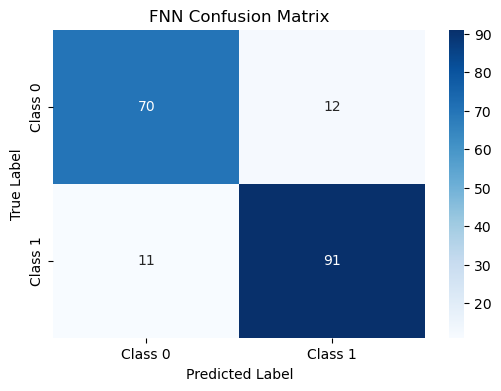

F1 Score: 0.8878


In [168]:
# Plot Confusion Matrix

conf_matrix = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(conf_matrix, "FNN Confusion Matrix")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")